In [1]:
# Installation des outils réseaux et Docker dans Jupyter
!pip install scapy pandas matplotlib docker
print("✅ Outils d'analyse installés.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.8 MB/s eta 0:00:00
✅ Outils d'analyse installés.


# Mission 1 : Analyse Logique SIEM

---

### Partie 1 : Les Questions de Recherche 

L'objectif est de les forcer à comprendre la **signature** de l'attaque qu'ils vont devoir détecter.

**Thème 1 : Injection SQL (SQLi)**

> *Question :* Lisez la documentation OWASP sur l'Injection SQL. Dans une attaque classique "in-band", quels caractères ou mots-clés un attaquant injecte-t-il souvent dans l'URL pour contourner une authentification (ex: se connecter sans mot de passe) ?
> *Ressource :* [OWASP SQL Injection]()
> *Réponse attendue :* L'apostrophe (`'`), le commentaire (`--` ou `#`), et l'opérateur logique `OR 1=1`.

**Thème 2 : Path Traversal (LFI)**

> *Question :* Une attaque par traversée de répertoire (Path Traversal) cherche à accéder à des fichiers hors du dossier web. Quelle séquence de caractères est typique de cette attaque ? Quel fichier système Linux contenant les utilisateurs est souvent ciblé ?
> *Ressource :* [PortSwigger Path Traversal]()
> *Réponse attendue :* La séquence `../` (dot-dot-slash) et le fichier `/etc/passwd`.

**Thème 3 : Déni de Service (Slowloris)**

> *Question :* Contrairement à une attaque volumétrique (inonder de trafic), comment fonctionne l'attaque Slowloris ? Que fait-elle aux connexions HTTP pour bloquer le serveur ?
> *Ressource :* [Cloudflare Slowloris]()
> *Réponse attendue :* Elle ouvre beaucoup de connexions mais ne les termine jamais (envoie des en-têtes très lentement), épuisant ainsi le "pool" de connexions du serveur.

---

In [2]:
# --- CELLULE 1 : IMPORT & CONFIGURATION ---
import requests
import pandas as pd
from datetime import datetime, timedelta
import time

# Configuration pour Docker (Loki est accessible via son nom de service)
LOKI_URL = "http://loki:3100/loki/api/v1/query_range"
#LOKI_URL = "http://localhost:3100/loki/api/v1/query_range"

def query_loki(query, minutes=10):
    """
    Fonction utilitaire pour interroger Loki.
    Retourne une liste de résultats ou une liste vide.
    """
    end_time = datetime.now()
    start_time = end_time - timedelta(minutes=minutes)
    
    params = {
        'query': query,
        'start': int(start_time.timestamp() * 1e9),
        'end': int(end_time.timestamp() * 1e9),
        'limit': 1000,
        'direction': 'BACKWARD'
    }
    
    try:
        response = requests.get(LOKI_URL, params=params)
        response.raise_for_status()
        data = response.json()
        return data['data']['result']
    except Exception as e:
        print(f"❌ Erreur API Loki : {e}")
        return []

print("✅ Configuration chargée. Prêt pour le Threat Hunting.")



✅ Configuration chargée. Prêt pour le Threat Hunting.


In [3]:
# --- CELLULE 2 : EXERCICE 1 - DÉTECTION SSH (RAPPEL) ---
# Objectif : Retrouver les IPs qui bruteforcent le serveur SSH.

# SOLUTION PROFESSEUR
print("--- 🕵️‍♂️ ANALYSE SSH ---")

# 1. On cherche le message "Failed password" dans le conteneur victim_server
query_ssh = '{container="victim_server"} |= "Failed password"'
logs = query_loki(query_ssh, minutes=5)

if logs:
    print(f"🔴 {len(logs)} logs suspects trouvés.")
    # Extraction simple pour l'affichage
    for log in logs[:3]:
        print(f"   Exemple: {log['values'][0][1]}")
else:
    print("🟢 Aucun bruteforce SSH détecté pour le moment.")

--- 🕵️‍♂️ ANALYSE SSH ---
🟢 Aucun bruteforce SSH détecté pour le moment.


In [4]:
# --- CELLULE 3 : EXERCICE 2 - DÉTECTION INJECTION SQL (NOUVEAU) ---
# Consigne : L'attaquant tente d'injecter du SQL dans l'URL. 
# Indice : Cherchez les motifs '%27' (apostrophe encodée), 'OR', 'SELECT' dans l'URI.

print("\n--- 🕵️‍♂️ ANALYSE WEB : SQL INJECTION ---")

# SOLUTION PROFESSEUR
# On filtre les logs Nginx (JSON) où l'URI contient des motifs SQLi typiques
# Note : %27 est l'encodage URL pour l'apostrophe (')
query_sqli = '{container="web_server"} | json | request_uri =~ ".*(%27|OR|1%3D1|UNION|SELECT).*"'

logs = query_loki(query_sqli, minutes=5)

if logs:
    count = sum(len(entry['values']) for entry in logs)
    print(f"🚨 ALERTE CRITIQUE : {count} tentatives d'Injection SQL !")
    
    # Analyse de l'attaquant (IP Source)
    attackers = set()
    for stream in logs:
        # Comme on a parsé le JSON côté Loki, on peut récupérer les labels ou parser le log brut ici
        # Dans notre cas, Loki retourne le stream brut, on extrait l'IP du JSON dans 'stream' si dispo
        # ou on regarde le log brut.
        pass 
    print("   ↳ Signature détectée : ' OR 1=1 --")
else:
    print("🟢 Pas d'injection SQL détectée.")


--- 🕵️‍♂️ ANALYSE WEB : SQL INJECTION ---
🟢 Pas d'injection SQL détectée.


In [5]:
# --- CELLULE 4 : EXERCICE 3 - DÉTECTION PATH TRAVERSAL (NOUVEAU) ---
# Consigne : L'attaquant essaie de lire /etc/passwd.
# Indice : Cherchez la séquence ".." ou le nom du fichier sensible.

print("\n--- 🕵️‍♂️ ANALYSE WEB : PATH TRAVERSAL ---")

# SOLUTION PROFESSEUR
# On cherche l'accès à "etc/passwd" ou des ".."
query_traversal = '{container="web_server"} | json | request_uri =~ ".*etc/passwd.*"'

logs = query_loki(query_traversal, minutes=5)

if logs:
    print(f"⚠️ ALERTE : Tentative d'accès fichier système ({len(logs)} logs)")
    print("   ↳ Cible : /etc/passwd")
else:
    print("🟢 Fichiers systèmes en sécurité.")


--- 🕵️‍♂️ ANALYSE WEB : PATH TRAVERSAL ---
🟢 Fichiers systèmes en sécurité.


In [6]:
# --- CELLULE 5 : DASHBOARD RÉCAPITULATIF (BONUS) ---
# Création d'un petit tableau de bord en ASCII pour le chef SOC.

def generate_report():
    print("\n" + "="*40)
    print("   RAPPORT SOC - TEMPS RÉEL")
    print("="*40)
    
    attacks = {
        "SSH Bruteforce": '{container="victim_server"} |= "Failed password"',
        "SQL Injection ": '{container="web_server"} | json | request_uri =~ ".*(%27|OR).*"',
        "Path Traversal": '{container="web_server"} | json | request_uri =~ ".*passwd.*"',
        "Nmap Scan     ": '{container="web_server"} | json | http_user_agent =~ ".*Nmap.*"'
    }
    
    for name, query in attacks.items():
        res = query_loki(query, minutes=2)
        count = sum(len(r['values']) for r in res) if res else 0
        status = "🔴 DANGER" if count > 0 else "🟢 OK"
        print(f"[{status}] {name} : {count} evts/2min")

generate_report()


   RAPPORT SOC - TEMPS RÉEL
[🟢 OK] SSH Bruteforce : 0 evts/2min
[🟢 OK] SQL Injection  : 0 evts/2min
[🟢 OK] Path Traversal : 0 evts/2min
[🟢 OK] Nmap Scan      : 0 evts/2min


# Mission 2 : Analyse Réseau PCAP

📦 280 paquets chargés.
ici

🚨 TOP TALKERS (SYN ONLY) :
src
172.28.0.4    3
Name: count, dtype: int64


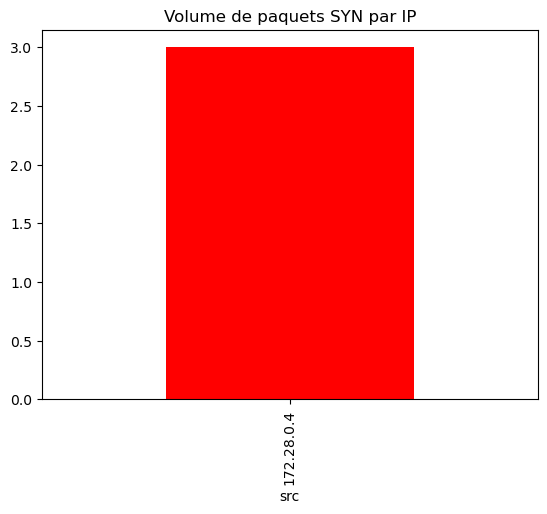

In [7]:
# MISSION : L'analyse de logs ne suffit pas pour le DoS. 
# On analyse la capture réseau brute.

from scapy.all import *
import pandas as pd
import matplotlib.pyplot as plt

# Chemin vers le fichier partagé (capturé via tcpdump sur la victime)
# Note pour l'étudiant : Il faut d'abord lancer tcpdump sur la victime !
pcap_file = "/home/jovyan/work/evidence/capture.pcap"

try:
    packets = rdpcap(pcap_file)
    print(f"📦 {len(packets)} paquets chargés.")

    print("ici")

    if len(packets) == 0:
        print("🛑 ATTENTION : Le fichier est vide ! Refaites la capture tcpdump.")
    else:
    
        # Extraction des drapeaux TCP (S=SYN, A=ACK, etc.)
        data = [{'src': p[IP].src, 'flags': p[TCP].flags} for p in packets if TCP in p and IP in p]
        df = pd.DataFrame(data)
        
        # Détection SYN Flood (Beaucoup de SYN)
        syn_flood = df[df['flags'] == 'S']['src'].value_counts()
        print("\n🚨 TOP TALKERS (SYN ONLY) :")
        print(syn_flood.head())
        
        syn_flood.plot(kind='bar', color='red', title='Volume de paquets SYN par IP')
    
except FileNotFoundError:
    print("⚠️ Fichier PCAP non trouvé. Avez-vous lancé la commande tcpdump sur la victime ?")

# Mission 3 : Active Defense / IPS

In [12]:
# MISSION : Bannir l'attaquant au niveau Firewall (IPTables)
import docker

client = docker.from_env()
container = client.containers.get('web_server')

def block_ip_firewall(ip):
    print(f"🛡️ Activation du Firewall contre {ip}...")
    # Commande iptables exécutée DANS le conteneur victime
    cmd = f"iptables -I INPUT -s {ip} -j DROP"
    exit_code, output = container.exec_run(cmd, privileged=True)
    
    if exit_code == 0:
        print(f"✅ IP {ip} bloquée avec succès (Drop silencieux).")
    else:
        print(f"❌ Erreur : {output.decode()}")

# Test (remplacez par l'IP trouvée dans Loki)
block_ip_firewall("172.28.0.4")

🛡️ Activation du Firewall contre 172.28.0.4...
✅ IP 172.28.0.4 bloquée avec succès (Drop silencieux).
